# Model 1: Train and Evaluation Fully Connected Neural Network

In [16]:
from pathlib import Path
import torch 
import numpy as np
from torch.utils.data import DataLoader

In [17]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [18]:
import sys; sys.path.insert(0, '/mnt/src')

## Read Datasets from .csv

In [19]:
from utils.file_io import read_angle_datasets

In [20]:
feature_columns = [
    'left_boom_base_yaw_joint', 
    'left_boom_base_pitch_joint',
    'left_boom_main_prismatic_joint',
    'left_boom_second_roll_joint',
    'left_boom_second_yaw_joint',
    'left_boom_top_pitch_joint',
    'left_boom_ee_joint',
    'cable1_property(length,youngsmodule(bend,twist))',
    'cable2_property(length,youngsmodule(bend,twist))',
    'cable3_property(length,youngsmodule(bend,twist))'
]

label_features = [
    ('cable1_lowest_point', np.array([2], dtype=np.int64)),
    ('cable2_lowest_point', np.array([2], dtype=np.int64)),
    ('cable3_lowest_point', np.array([2], dtype=np.int64))
]

normalized_features = [
    ('cable1_property(length,youngsmodule(bend,twist))', np.array([1,2], dtype=np.int64)),
    ('cable2_property(length,youngsmodule(bend,twist))', np.array([1,2], dtype=np.int64)),
    ('cable3_property(length,youngsmodule(bend,twist))', np.array([1,2], dtype=np.int64))
]

In [21]:
data_folder = Path("/mnt/data/")
train_data, test_data = read_angle_datasets(data_folder, 0.9, feature_columns, label_features, normalized_features=normalized_features)

Reading .csv files: 1it [00:00,  2.42it/s]
/mnt/src/utils/preprocessing.py:132: RuntimeWarning: divide by zero encountered in divide
  return np.where(x_max != x_min, (features - x_min) / (x_max - x_min), 1).astype(dtype=np.float32)
/mnt/src/utils/preprocessing.py:132: RuntimeWarning: invalid value encountered in divide
  return np.where(x_max != x_min, (features - x_min) / (x_max - x_min), 1).astype(dtype=np.float32)


Preprocessing dataframe
Reshaping dataframe for learning


In [22]:
input_shape, output_shape = train_data[0][0].shape[0], train_data[0][1].shape[0]
print(f"Data shape {input_shape} / {output_shape} of total {len(train_data) + len(test_data)} data rows!")

Data shape 16 / 3 of total 10522 data rows!


/mnt/src/utils/angle_dataset.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return row[0], row[1]


## Load parameter, functions and dataloader

In [23]:
from utils.file_io import define_dataloader_from_angle_dataset
import os
import ast
from dotenv import load_dotenv

In [24]:
model_path = Path("/mnt/models/fully_connected/").absolute()

In [25]:
dotenv_path = model_path / ".env"
load_dotenv(dotenv_path=dotenv_path)

learning_rate = float(os.getenv("LEARNING_RATE"))
batch_size = int(os.getenv("BATCH_SIZE"))
hidden_activation = os.getenv("HIDDEN_ACTIVATION")
optimizer = os.getenv("OPTIMIZER")
hidden_layers = ast.literal_eval(os.getenv("HIDDEN_LAYERS"))
dropout = float(os.getenv("DROPOUT"))
num_epochs = int(os.getenv("NUM_EPOCHS"))

In [26]:
train_dataloader, validation_dataloader, test_dataloader, visualization_dataloader = define_dataloader_from_angle_dataset(train_data, test_data, batch_size, split_size=0.95, visualization_split=0.9)

## Load and Train the model

In [27]:
from models.fully_connected import FullyConnected, train
from utils.loss_functions import get_loss_function
from utils.optimizer import get_optimizer_function
from utils.activation import get_activation
from utils.early_stopping import EarlyStopping

In [28]:
early_stopping = EarlyStopping(10)

In [29]:
activation = get_activation(hidden_activation)
model = FullyConnected(input_shape, hidden_layers, output_shape, dropout, activation)
optimizer = get_optimizer_function(optimizer, model, learning_rate)
loss_function = get_loss_function()

In [30]:
_, validation_losses = train(num_epochs, train_dataloader, validation_dataloader, model, loss_function, optimizer, model_path, device, early_stopping=early_stopping)

Epoch: 1
Loss on train: 0, loss on validation: 1.7035341262817383
Epoch: 2
Loss on train: 0, loss on validation: 0.8281034231185913
Epoch: 3
Loss on train: 0, loss on validation: 1.53080153465271
Epoch: 4
Loss on train: 0, loss on validation: 1.5460619926452637
Epoch: 5
Loss on train: 0, loss on validation: 0.8573321104049683
Epoch: 6


KeyboardInterrupt: 

In [31]:
model.eval()

FullyConnected(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Sequential(
    (linear_1): Linear(in_features=16, out_features=30, bias=True)
    (hidden_activation_1): GELU(approximate='none')
    (dropout_2): Dropout(p=0.0695558742085019, inplace=False)
    (linear_2): Linear(in_features=30, out_features=28, bias=True)
    (hidden_activation_2): GELU(approximate='none')
    (dropout_3): Dropout(p=0.0695558742085019, inplace=False)
  )
  (last): Linear(in_features=28, out_features=3, bias=True)
)

## Evaluation

In [32]:
from utils.evaluation import compute_losses_from, compute_predictions
from utils.visualization import create_plot_for_dimensions, create_inference_time_plot, create_validation_loss_plot

In [33]:
model_state_dict = torch.load(model_path / "checkpoint.pt")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## 1. Analysis: Compute test loss

In [38]:
y, y_true, inference_times = compute_predictions(visualization_dataloader, model, 'cpu')
test_losses = compute_losses_from(y, y_true, loss_function)
print(f"The mean squared error of the loaded model on test is: {test_losses.mean()}")
print(y.shape)

The mean squared error of the loaded model on test is: 1.0532532930374146
torch.Size([107, 3])


/mnt/src/utils/angle_dataset.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return row[0], row[1]


## 2. Analysis: Show Cable lowest points

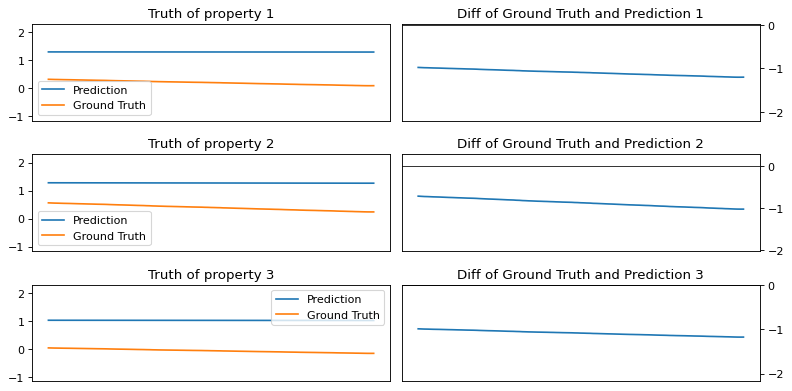

In [35]:
plot = create_plot_for_dimensions(y.numpy(), y_true.numpy(), size=5)
plot.savefig(model_path / "predictions.png")
plot.show()

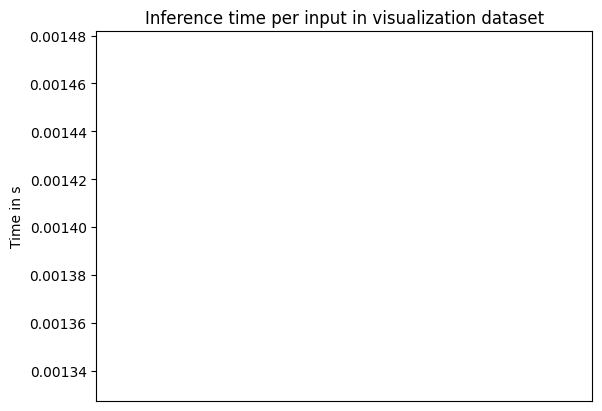

In [36]:
plot = create_inference_time_plot(inference_times.numpy())
plot.savefig(model_path / "inference_times.png")
plot.show()

## 4. Analysis: Show validation loss over time

In [37]:
plot = create_validation_loss_plot(validation_losses)
plot.savefig(model_path / "losses.png")
plot.show()

NameError: name 'validation_losses' is not defined